## Library import

In [1]:
import numpy as np 
import pandas as pd
import math
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import matplotlib as mlp
from matplotlib import rcParams
import itertools
import matplotlib.font_manager

## Function

In [2]:
# Degree to Kelvin  
def D2K(val): 
    return val + 273.15 
def K2D(val):
    return val - 273.15

# 선형보간 함수
def interpolate_list(lst,n):
    result = []
    for i in range(len(lst)-1):  # 리스트 길이보다 하나 작은 숫자로 포문을 돌림 -> 마지막에는 포문으로 선형보간 없이 자기 자신만 추가해줘야함 -> 하지만 23:55 까지만 데이터를 얻을 것이기 때문에 추가 따로 안하고 마지막 값은 안들어가는 걸로 했음
        result.append(round(lst[i],2))   # 각 인자들을 빈 리스트인 result에 하나씩 넣음 
        x1, x2 = lst[i], lst[i+1] # 각 x1, x2를 리스트에 있는 i번째 값, i+1번째 값으로 선언 
        y = n + 1                               
        slope = (x2-x1)/y    # x + slope*n 에 쓰일 것
        for i in range(1,n+1):     # x1 데이터 넣고 선형보간한 것 채워넣기
            x2 = x1 + slope*(i) # +1 을 한 이유는 range가 0부터 넣기 때문
            result.append(round(x2,2))
    result.append(lst[-1])
            
    return result

## Constant

In [3]:
# Boltzmann
epsilon = 0.92
alpha = 0.3
sigma = 5.67*10**(-8)
k_D = 0.000462
k_d = 0.0014


# dew point temp 계산하기 위한 상수 (-45~60도까지 고정)
b = 17.62
c = 243.12

## 대류 열 전달 계수 계산하기 위한 상수
Roughness_dict = {"Very Rough"   : {"D": 11.58, "E" : 5.894, "F" :    0.0}, # Stucoo 
                  "Rough"        : {"D": 12.49, "E" : 4.065, "F" :  0.028}, # Brick
                  "Medium Rough" : {"D": 10.79, "E" : 4.192, "F" :    0.0}, # Concrete
                  "Medium Smooth": {"D":  8.23, "E" : 4.000, "F" : -0.057}, # Clear pine
                  "Smooth"       : {"D": 10.22, "E" : 3.100, "F" :    0.0}, # Smooth Plaster
                  "Very Smooth"  : {"D":  8.23, "E" : 3.300, "F" : -0.036}, # Glass 
                  }

## Set Time Step

In [4]:
# set timestep, duration
t = 600 # [s]   # time step
duration = 8760 # [h] #168시간에 대하여 해석
infN = 9
# unit change 
hour_to_sec = 3600
min_to_sec = 60  
day_to_hour = 24

# timestep list
#t_list = [t*i for i in range(int(duration*hour_to_sec/t)-infN)]
t_list = [t*i for i in range(int(duration*hour_to_sec/t))]
len(t_list)

52560

## Boundary Condition

In [5]:
df_BC = pd.read_csv('../data1/data.csv')
T_oa = (D2K(df_BC.loc[:, 'Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'])).tolist()
T_ia = [D2K(20) for _ in range(len(t_list))]
T_gnd = (D2K(df_BC.loc[:, 'Environment:Site Surface Ground Temperature [C](TimeStep)'])).tolist()
T_MRT = T_ia
I_DV = (df_BC.loc[:, 'ZN001:WALL001:Surface Outside Face Incident Beam Solar Radiation Rate per Area [W/m2](TimeStep)'])
I_dH = (df_BC.loc[:, 'ZN001:WALL001:Surface Outside Face Incident Sky Diffuse Solar Radiation Rate per Area [W/m2](TimeStep)']) + (df_BC.loc[:, 'ZN001:WALL001:Surface Outside Face Incident Ground Diffuse Solar Radiation Rate per Area [W/m2](TimeStep)'])
I = I_DV + I_dH
s_DV = (k_D*I_DV**0.9)
s_dH = (k_d*I_dH**0.9)
s = s_DV + s_dH
q_alpha = (I * alpha).tolist()
T_tv = (I/s)
T_tv = T_tv.fillna(0).tolist()
s = s.tolist()

# Relative Humidity
RH = (df_BC.loc[:, 'Environment:Site Outdoor Air Relative Humidity [%](TimeStep)']).tolist() # [%]

# View factor
Fsky = 0.5
Fgnd = 1 - Fsky

# Heat transfer coefficient
Vz = np.array(df_BC.loc[:, 'Environment:Site Wind Speed [m/s](TimeStep)'])
h_ci = 4
h_co = (Roughness_dict["Medium Rough"]["D"] + Roughness_dict["Medium Rough"]["E"]*Vz+ Roughness_dict["Medium Rough"]["F"]*Vz**2).tolist()  # [W/m2K]
h_ro = 5.5 # [W/m2K] 모든 계절에 대한 radiative transfer coefficient
h_ri = 5.5

T_SE = alpha*I/h_ro 

## Boundary Condition (변경 X)

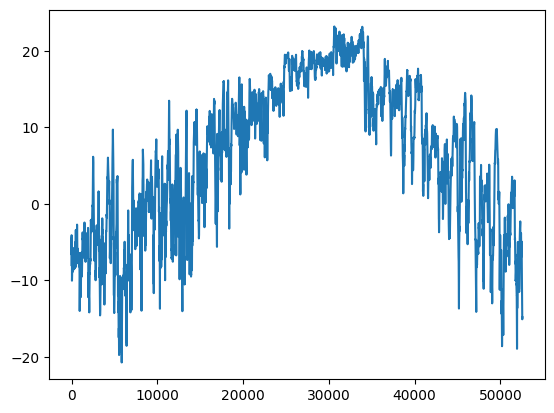

In [13]:
# 이 항목은 개별적으로 변경할 수 없는 조건에 대해 작성

t_dp = [] # 이슬점 온도 [C]
epsilon_sky = [] # Tsky를 구하기 위한 clear sky에 대한 방사율 (could sky에 대한 고려X)
T_sky = [] # [K]
T_rad = []

for i in range(len(t_list)):
    t_dp.append(c*(math.log(RH[i]/100)+((b*K2D(T_oa[i]))/(c+K2D(T_oa[i])))) / (b-math.log(RH[i]/100)+(b*K2D(T_oa[i])/(c+K2D(T_oa[i])))))
    epsilon_sky.append(0.711+(0.56*10**(-2))*t_dp[i]+(0.73*10**(-4))*(t_dp[i]**2))
    T_sky.append((epsilon_sky[i]**(1/4))*T_oa[i])
    T_rad.append(Fsky*T_sky[i] + Fgnd*T_gnd[i])
df_T_sky = pd.DataFrame(T_sky)
df_T_dp = pd.DataFrame(t_dp)
plt.plot(df_T_dp)

In [14]:
BC = {'T_oa': T_oa,
      'T_ia': T_ia,
        'T_sky': T_sky,
        'I': I,
        'h_co': h_co,
        'T_SE':T_SE}
BC_data = pd.DataFrame(BC)

# CSV 파일로 저장
BC_data.to_csv('../data/BC_data.csv', index=False)

## Dictionary

### set material 

In [11]:
# Concrete Dense 
concrete_dict =    {"Length"                 :  0.02, # [m]
                    "Thermal_conductivity"   :   1.4, # [W/(m*K)]
                    "Specific_heat"          :  1000, # [J/(Kg*K)]
                    "Density"                :  2200, # [kg/m3] 
                    "Divide"                 :     2, # [None]
                     } 
concrete_dict['Volumetric_heat_capcity'] = concrete_dict["Specific_heat"]*concrete_dict["Density"] # 체적열용량은 따로추가 직접 계산 번거로움 감소

# Expanded polystyrene
insulation_1_dict = {"Length"                :  0.05, # [m]
                     "Thermal_conductivity"  :  0.03, # [W/(m*K)]
                     "Specific_heat"         :  1400, # [J/(Kg*K)]
                     "Density"               :    25, # [kg/m3] 
                     "Divide"                :     3, # [None]
                     }  
insulation_1_dict['Volumetric_heat_capcity'] = insulation_1_dict["Specific_heat"]*insulation_1_dict["Density"]

## Set system

In [12]:
M_dict1 = concrete_dict
M_dict2 = concrete_dict
M_dict3 = concrete_dict
M_dict4 = concrete_dict
M_dict5 = concrete_dict

In [13]:
# 총 셀 노드 개수 변수
N = M_dict1["Divide"] + M_dict2["Divide"] + M_dict3["Divide"] + M_dict4["Divide"] + M_dict5["Divide"]
# 초기온도 
initial_temp = D2K(20) 
# --------------------------------------------------------------------------------------------

## 벽체의 열물성을 담은 리스트 정의 [list]
# --------------------------------------------------------------------------------------------
del_x = []
k = []
c = []
rho = []
C = []
K = []
R = [] 
for Midx in [M_dict1, M_dict2, M_dict3, M_dict4, M_dict5]: # Material dict를 넣어줌
    for _ in range(Midx["Divide"]):  # Divide 개수 만큼 복붙
        del_x.append(Midx["Length"]/Midx["Divide"])
        k.append(Midx["Thermal_conductivity"])
        c.append(Midx["Specific_heat"])
        rho.append(Midx["Density"])
        C.append(Midx["Volumetric_heat_capcity"])
        # k/x
        R.append((Midx["Length"]/Midx["Divide"])
                 
                                /Midx["Thermal_conductivity"])
        # x/k
        K.append(Midx["Thermal_conductivity"]
                                /(Midx["Length"]/Midx["Divide"]))
        
# 열전달계수, Tsol 정의 # 온도가 다 초기온도로 들어가있기 때문에 Tridigonal matrix 에서 온도를 업데이트 시키며 같이 업데이트 시켜야함
# --------------------------------------------------------------------------------------------  

x = [del_x[i]/2 for i in range(0, N)] # 셀 절반의 길이

# left

del_x_left = [(del_x[i-1] + del_x[i])/2 for i in range(1, N)] # i=0일 때 i-1 정의 불가
del_x_left.insert(0,del_x[0]/2) # -- 위 컴프리핸션 포문에서 정의할 수 없으므로 따로 정의

R_left =     [(del_x[i-1]/2)/k[i-1]
                +(del_x[i]/2)/k[i]
                for i in range(1,N)]

R_left.insert(0,R[0]/2) # -- 위 컴프리핸션 포문에서 정의할 수 없으므로 따로 정의

K_left = [1/R_left[i] for i in range(N)] # R의 역수로 정의

# right
del_x_right = [(del_x[i] + del_x[i+1])/2 for i in range(N-1)] # i= N일 때 i+1 정의 불가 
del_x_right.append(del_x[N-1]/2) # -- 위 컴프리핸션 포문에서 정의할 수 없으므로 따로 정의 N-1 -> list 에서는 14번째 값

R_right =     [(del_x[i]/2)/k[i]
                +(del_x[i+1]/2)/k[i+1]
                for i in range(N-1)]
R_right.append(R[N-1]/2) # -- 위 컴프리핸션 포문에서 정의할 수 없으므로 따로 정의

K_right = [1/R_right[i] for i in range(N)] # R의 역수로 정의

## Get Temperature

In [14]:
# 온도 정보를 담을 행렬 [matrix]
# --------------------------------------------------------------------------------------------
T = []
T_left = []
T_right = []

# 온도 정보 전부 초기온도로 일단 담기 (해당 매트릭스를 포함하는 리스트들은 모두 T가 업데이트 됨에 따라 업데이트 해줘야함)
for _ in range(len(t_list)):

    T.append([initial_temp for _ in range(N)])
    T_left.append([initial_temp for _ in range(N)])
    T_right.append([initial_temp for _ in range(N)])

# 초기 표면 온도 계산
T_left[0][0] = (h_ro*((q_alpha[0]/h_ro)+Fsky*T_sky[0]+Fgnd*T_gnd[0])+h_co[0]*T_oa[0]+(T[0][0]/R_left[0]))/((1/R_left[0])+h_ro+h_co[0])


#  T가 업데이트 됨에 따라 업데이트가 필요한 값 T_left[n][0] 대신 T[n][0]으로 계산해준다
    

# q_sol (alpha)


## Tridiagonal matrix
# --------------------------------------------------------------------------------------------

#          | b1 c1  0  0  0 |   | T[n+1][1] |      | g1 |    
#          | a2 b2 c2  0  0 |   | T[n+1][2] |      | g2 |               
#          |  0 a3 b3 c3  0 | . | T[n+1][3] |   =  | g3 |      
#          |  0  0 a4 b4 c4 |   | T[n+1][4] |      | g4 |
#          |  0  0  0 a5 b5 |   | T[n+1][5] |      | g5 |

#                  A{matrix}  *   T{vector}     = B{vector}
#          특정 타임스탭에서 정의했을 때 벡터인 것이지 이것이 누적되어 결국 matrix로 나옴

# a,b,c [list]
a_list = [-t*K_left[i] for i in range(N)]
b_list = [2*del_x[i]*C[i]+t*K_left[i]+t*K_right[i] for i in range(N)]
c = [-t*K_right[i] for i in range(N)]

# A matrix -> 미리 알 수 있는 값
A = np.zeros((N, N)) # 임시로 0값을 가지는 NxN 행렬 만들기

for idx in range(N-1): # A matrix에 a,b,c 리스트 넣어주기

    A[idx+1][idx] = a_list[idx+1]
    A[idx][idx] = b_list[idx]
    A[N-1][N-1] = b_list[N-1]
    A[idx][idx+1] = c[idx]
A_inv = np.linalg.inv(A) # 역행렬 미리 만들어두기
# B matrix -> g 벡터들을 넣어준다 

for n in range(len(t_list)-1): # 타임스탭 for 문 
    B = [] # 타임스탭마다 새롭게 정의해줘야함
    # B list 정의하기 
    for i in range(1,N-1): # node for 문
        B.append([t*K_left[i]*T[n][i-1]+(2*del_x[i]*C[i]-t*K_left[i]-t*K_right[i])*T[n][i]+t*K_right[i]*T[n][i+1]]) # g_i 추가 열벡터로 표현하기 위해 [] 를 씌워줌
    B.insert(0,[2*t*K_left[0]*T_left[n][0]     # 복사, 대류를 고려해서 T_os를 구했기 때문에 그대로 가져다 쓰면 됨
                + (2*del_x[0]*C[0]-t*K_left[0]-t*K_right[0])*T[n][0] 
                + t*K_right[0]*T[n][1]])  
    B.append([t*K_left[N-1]*T[n][N-2]    
                + (2*del_x[N-1]*C[N-1]-t*K_left[N-1]-t*K_right[N-1])*T[n][N-1] 
                + 2*t*K_right[N-1]*T_right[n][N-1]])                     # 그렇게 하기 위해선 Excel로 뽑아 놓았던 데이터를 참고해야함
                   # 그렇게 하기 위해선 Excel로 뽑아 놓았던 데이터를 참고해야함
                   
                       # T[n+1] 값 구하고 업데이트 필요한 값들 업데이트 
    for i in range(N): # node for 문 # [0] 은 T가 이중 리스트이기 때문에 리스트를 한 겹 벗겨내기 위함 
        T[n+1][i] = np.dot(A_inv, B)[i][0] # tridiagonal matrix 에서 구한 T[n+1] 값을 다음 계산될 T[n] 리스트 값에 정의
        
    for i in range(1,N):
        T_left[n+1][0] = (h_ro*((q_alpha[n+1]/h_ro)+Fsky*T_sky[n+1]+Fgnd*T_gnd[n+1])+h_co[n+1]*T_oa[n+1]+(T[n+1][0]/R_left[0]))/((1/R_left[0])+h_ro+h_co[n+1])
        T_left[n+1][i] = T[n+1][i-1]+(T[n+1][i]-T[n+1][i-1])*(x[i-1]/(x[i-1]+x[i]))
    for i in range(0,N-1):
        T_right[n+1][i] = T[n+1][i]+(T[n+1][i+1]-T[n+1][i])*(x[i]/(x[i]+x[i+1])) 
        T_right[n+1][N-1] = T[n+1][N-1] - (T[n+1][N-1]-T_ia[n+1])*R_right[N-1]/(R_right[N-1]+(1/h_ci))


# half time step에 대한 온도를 담을 행렬
T_half = []
T_left_half = []
T_right_half = []
T_oa_half = []

for _ in range(len(t_list)):
    T_half.append([initial_temp for _ in range(N)])
    T_left_half.append([initial_temp for _ in range(N)])
    T_right_half.append([initial_temp for _ in range(N)])
    T_oa_half.append(initial_temp)

# 첫 번째 행의 값 -> 0 타임스탭
# 두번째 행의 값 -> 0.5 타임스탭으로 만들기 위해 n+1 항에 대해 정의해줌
for n in range(len(t_list)-1):
    for i in range(0, N):
        T_half[n+1][i] = (T[n][i] + T[n+1][i])/2
        T_left_half[n+1][i] = (T_left[n][i] + T_left[n+1][i])/2
        T_right_half[n+1][i] = (T_right[n][i] + T_right[n+1][i])/2
    
    T_oa_half[n+1] = (T_oa[n] + T_oa[n+1])/2


df_T = K2D(pd.DataFrame(T))
df_T_right = K2D(pd.DataFrame(T_right))
df_T_left = K2D(pd.DataFrame(T_left))
df_T_left_half = K2D(pd.DataFrame(T_left_half))
df_T_half = K2D(pd.DataFrame(T_half))

df_T.to_csv('../data/df_T.csv', index= False)
df_T_right.to_csv('../data/df_T_right.csv', index= False)
df_T_left.to_csv('../data/df_T_left.csv', index= False)

### 확인용

In [15]:
q_sky = []
q_gnd = []
q_cv = []
q_cd = []
T_left_sky = []
T_left_sun = []
T_left_gnd = []
T_left_cv = []
T_left_cd = []
q_check = []

q_sky = [0 for _ in range(len(t_list))]
q_gnd = [0 for _ in range(len(t_list))]
q_cv = [0 for _ in range(len(t_list))]
q_cd = [0 for _ in range(len(t_list))]
T_left_sky = [0 for _ in range(len(t_list))]
T_left_sun = [0 for _ in range(len(t_list))]
T_left_gnd = [0 for _ in range(len(t_list))]
T_left_cv = [0 for _ in range(len(t_list))]
T_left_cd = [0 for _ in range(len(t_list))]
q_check = [0 for _ in range(len(t_list))]

for n in range(len(t_list)):
    q_sky[n] = Fsky*h_ro*(T_sky[n]-T_left[n][0])
    q_gnd[n] = Fgnd*h_ro*(T_gnd[n]-T_left[n][0])
    q_cv[n] = h_co[n]*(T_oa[n]-T_left[n][0])
    q_cd[n] = (1/R_left[0])*(T_left[n][0]-T[n][0])
    T_left_sun[n] = q_alpha[n]/((1/R_left[0])+h_ro+h_co[n])
    T_left_sky[n] = h_ro*(Fsky*T_sky[n])/((1/R_left[0])+h_ro+h_co[n])
    T_left_gnd[n] = h_ro*(Fgnd*T_gnd[n])/((1/R_left[0])+h_ro+h_co[n])
    T_left_cv[n] = h_co[n]*T_oa[n]/((1/R_left[0])+h_ro+h_co[n])
    T_left_cd[n] = (T[n][0]/R_left[0])/((1/R_left[0])+h_ro+h_co[n])


q_BL = {'q_sky': q_sky,
        'q_gnd': q_gnd,
        'q_cv': q_cv,
        'q_cd' : q_cd,
        'T_left_sun': (T_left_sun),
        'T_left_sky': (T_left_sky),
        'T_left_gnd': (T_left_gnd),
        'T_left_cv': (T_left_cv),
        'T_left_cd': (T_left_cd)}
df_q_BL = pd.DataFrame(q_BL)

# CSV 파일로 저장
df_q_BL.to_csv('../data_BL/q_BL data.csv', index=False)

## Get Heat Flux

In [16]:
# --------------------------------------------------------------------------------------------
# Heat flux

# external |<-------------------------------->| internal space
#          +    +    +    +    +    +    +    +
#         T_BC  0    1    2    3    4    5   T_is
#                --q_in->[2]--q_out-> 
#                       --q-> 
#                  q = [(q_in + q_out)/2]

initial_q = 0

q = []
q_in = []
q_out = []

for _ in range(len(t_list)):
    q.append([initial_q for _ in range(N)])
    q_in.append([initial_q for _ in range(N)])
    q_out.append([initial_q for _ in range(N)])

for n in range(len(t_list)):
    for i in range(1,N):
        q_in[n][i] = (-1)*K_left[i]*(T[n][i] - T[n][i-1])
        q_in[n][0] = K_left[0]*(T_left[n][0] - T[n][0])


    for i in range(0,N-1):
        q_out[n][i] = K_right[i]*(T[n][i] - T[n][i+1])
        q_out[n][N-1] = K_right[N-1]*(T[n][N-1] - T_right[n][N-1])
        
        q[n][i] = (q_in[n][i] + q_out[n][i])/2 
        q[n][N-1] = (q_in[n][N-1] + q_out[n][N-1])/2

q_half = []
q_in_half = []
q_out_half = []

for _ in range(len(t_list)):
    q_half.append([initial_q for _ in range(N)])
    q_in_half.append([initial_q for _ in range(N)])
    q_out_half.append([initial_q for _ in range(N)])

# 첫 번째 행의 값 -> 0 타임스탭
# 두번째 행의 값 -> 0.5 타임스탭으로 만들기 위해 n+1 항에 대해 정의해줌
for n in range(len(t_list)-1):
    for i in range(0, N):
        q_half[n+1][i] = (q[n][i] + q[n+1][i])/2
        q_in_half[n+1][i] = (q_in[n][i] + q_in[n+1][i])/2
        q_out_half[n+1][i] = (q_out[n][i] + q_out[n+1][i])/2


df_q = (pd.DataFrame(q))
df_q_in = (pd.DataFrame(q_in))
df_q_out = (pd.DataFrame(q_out))

df_q.to_csv('../data/df_q.csv', index= False)
df_q_in.to_csv('../data/df_q_in.csv', index= False)
df_q_out.to_csv('../data/df_q_out.csv', index= False)

## Entropy and Exergy

### system layer

In [17]:
# -------------------------------------------Entropy------------------------------------------------------------------------

## entropy equation
#
#  [Entropy inflow] + [Entropy generation rate] = [Entropy stored rate] + [Entropy outflow] 
# conduction 

entropy = 0 # [W/(m^2*K)]

entropy_if = []  # entropy inflow
entropy_gen = [] # entropy generation
entropy_st = []  # entropy stored
entropy_of = []  # entropy outflow

for _ in range(len(t_list)):
    entropy_if.append([entropy for _ in range(N)])
    entropy_gen.append([entropy for _ in range(N)])
    entropy_st.append([entropy for _ in range(N)])
    entropy_of.append([entropy for _ in range(N)])

# 첫 번째 행의 값 -> 0 타임스탭
# 두번째 행의 값 -> 0.5 타임스탭으로 만들기 위해 n+1 항에 대해 정의해줌 (맨 마지막 행에 대해 0이 나오지 않게)
for n in range(len(t_list)-1):
    for i in range(N):
        entropy_if[n+1][i] = q_in_half[n+1][i]/T_left_half[n+1][i]
        entropy_gen[n+1][i] = (del_x[i]/k[i])*(q_half[n+1][i]/T_half[n+1][i])*(q_half[n+1][i]/T_half[n+1][i])    
        entropy_gen[n+1][i] = del_x[i]*C[i]*((T[n+1][i]-T[n][i])/t*T_half[n+1][i])
        entropy_of[n+1][i] = q_out_half[n+1][i]/T_right_half[n+1][i]

df_entropy_if = (pd.DataFrame(entropy_if))
df_entropy_gen = (pd.DataFrame(entropy_gen))
df_entropy_st = (pd.DataFrame(entropy_st))
df_entropy_of = (pd.DataFrame(entropy_of))

df_entropy_if.to_csv('../data/df_entropy_if.csv', index= False)
df_entropy_gen.to_csv('../data/df_entropy_gen.csv', index= False)
df_entropy_st.to_csv('../data/df_entropy_st.csv', index= False)
df_entropy_of.to_csv('../data/df_entropy_of.csv', index= False)

# -------------------------------------------Exergy------------------------------------------------------------------------

# [exergy inflow] - [exergy consumption] = [stored exergy] + [exergy outflow]

exergy = 0 # [W/(m^2*K)]

exergy_if = []  #exergy inflow
exergy_c = []   #exergy consumption
exergy_st = []  #exergy stored
exergy_of = []  #exergy outflow

for _ in range(len(t_list)):
    exergy_if.append([exergy for _ in range(N)])
    exergy_c.append([exergy for _ in range(N)])
    exergy_st.append([exergy for _ in range(N)])
    exergy_of.append([exergy for _ in range(N)])

# 첫 번째 행의 값 -> 0 타임스탭
# 두번째 행의 값 -> 0.5 타임스탭으로 만들기 위해 n+1 항에 대해 정의해줌 (맨 마지막 행에 대해 0이 나오지 않게)
for n in range(len(t_list)-1):
    for i in range(N):
        exergy_if[n+1][i] = q_in_half[n+1][i]*(1-(T_oa_half[n+1]/T_left_half[n+1][i]))
        exergy_c[n+1][i] = (del_x[i]/k[i])*((T_oa_half[n+1]*q_half[n+1][i]/T_half[n+1][i])*(q_half[n+1][i]/T_half[n+1][i]))
        exergy_st[n+1][i] = del_x[i]*C[i]*(1-(T_oa[n]/T_half[n+1][i]))*((T[n+1][i]-T[n][i])/t)
        exergy_of[n+1][i] = q_out_half[n+1][i]*(1-(T_oa_half[n+1]/T_right_half[n+1][i]))

# Exergy inflow에서의 웜/쿨엑서지 판별 (카르노 계수 정의)
term1 = []
term2 = []
for _ in range(len(t_list)):
    term1.append([exergy for _ in range(N)])
    term2.append([exergy for _ in range(N)])

for n in range(len(t_list)-1):
    for i in range(N):
        term1[n+1][i] = q_in_half[n+1][i]
        term2[n+1][i] = (1-(T_oa_half[n+1]/T_left_half[n+1][i]))
df_term1 = pd.DataFrame(term1)
df_term2 = pd.DataFrame(term2)
        
# 새로운 데이터프레임 생성
exergy_if_warmcool = pd.DataFrame(index=df_term1.index, columns=df_term1.columns)

# 각 열을 비교하고 값을 할당
for col in df_term1.columns:
    condition_warm = ((df_term1[col] > 0) & (df_term2[col] > 0)) | ((df_term1[col] < 0) & (df_term2[col] > 0))
    condition_cool = ((df_term1[col] < 0) & (df_term2[col] < 0)) | ((df_term1[col] > 0) & (df_term2[col] < 0))

    exergy_if_warmcool.loc[condition_warm, col] = 'warm'
    exergy_if_warmcool.loc[condition_cool, col] = 'cool'
    exergy_if_warmcool.loc[~(condition_warm | condition_cool), col] = 'undefined'

df_exergy_if = (pd.DataFrame(exergy_if))
df_exergy_c = (pd.DataFrame(exergy_c))
df_exergy_st = (pd.DataFrame(exergy_st))
df_exergy_of = (pd.DataFrame(exergy_of))

exergy_if_warmcool.to_csv('../data/exergy_if_warmcool.csv', index= False)
df_exergy_if.to_csv('../data/df_exergy_if.csv', index= False)
df_exergy_c.to_csv('../data/df_exergy_c.csv', index= False)
df_exergy_st.to_csv('../data/df_exergy_st.csv', index= False)
df_exergy_of.to_csv('../data/df_exergy_of.csv', index= False)


### Ex Boundary layer

In [18]:
T_sky_half = []
T_gnd_half = []
T_rad_half = []
q_alpha_half = []
h_co_half = []
T_ia_half = []
T_MRT_half = []
s_half = []

T_sky_ini = T_sky[0]
h_co_ini = h_co[0]
s_ini = s[0]

for _ in range(len(t_list)):
    T_sky_half.append(T_sky_ini)
    T_gnd_half.append(initial_temp)
    T_rad_half.append(initial_temp)
    q_alpha_half.append(initial_q)
    h_co_half.append(h_co_ini)
    T_ia_half.append(initial_temp)
    s_half.append(s_ini)
    T_MRT_half.append(initial_temp)

for n in range(len(t_list)-1):
    T_sky_half[n+1] = (T_sky[n]+T_sky[n+1])/2
    T_gnd_half[n+1] = (T_gnd[n]+T_gnd[n+1])/2
    T_rad_half[n+1] = (T_rad[n]+T_rad[n+1])/2
    q_alpha_half[n+1] = (q_alpha[n]+q_alpha[n+1])/2
    h_co_half[n+1] = (h_co[n]+h_co[n+1])/2
    T_ia_half[n+1] = (T_ia[n]+T_ia[n+1])/2
    s_half[n+1] = (s[n]+s[n+1])/2
    T_MRT_half[n+1] = (T_MRT[n]+T_MRT[n+1])/2

# Boundary layer (radiation, convection)
entropy_if_BL = []
entropy_gen_BL = []
entropy_of_BL = []

exergy_if_BL = []
exergy_c_BL = []
exergy_of_BL = []

exergy_if_sun = []
exergy_if_sky = []
exergy_if_gnd = []
exergy_if_cv = []
exergy_c_sun = []
exergy_c_rad = []
exergy_of_os = []
exergy_of_cd = []

entropy_if_BL = [entropy for _ in range(len(t_list))]
entropy_gen_BL = [entropy for _ in range(len(t_list))]
entropy_of_BL = [entropy for _ in range(len(t_list))]

exergy_if_BL = [exergy for _ in range(len(t_list))]
exergy_c_BL = [exergy for _ in range(len(t_list))]
exergy_of_BL = [exergy for _ in range(len(t_list))]

exergy_if_sun = [exergy for _ in range(len(t_list))]
exergy_if_sky = [exergy for _ in range(len(t_list))]
exergy_if_gnd = [exergy for _ in range(len(t_list))]
exergy_if_cv = [exergy for _ in range(len(t_list))]
exergy_c_sun  = [exergy for _ in range(len(t_list))]
exergy_c_rad = [exergy for _ in range(len(t_list))]
exergy_of_os = [exergy for _ in range(len(t_list))]
exergy_of_cd = [exergy for _ in range(len(t_list))]

for n in range(len(t_list)-1):
    entropy_if_BL[n+1] = (
        alpha*s_half[n+1] + Fsky*epsilon*(4/3)*sigma*T_sky_half[n+1]**3 + Fgnd*epsilon*(4/3)*sigma*T_gnd_half[n+1]**3
        + (1/T_left_half[n+1][0])*(h_co_half[n+1]*(T_oa_half[n+1]-T_left_half[n+1][0]))
        )
    if T_tv[n+1] == 0:
        entropy_gen_BL[n+1] = (
        (epsilon*sigma*T_left_half[n+1][0]**3*(1/3+(T_rad_half[n+1]/T_left_half[n+1][0])**3*(T_rad_half[n+1]/T_left_half[n+1][0]-4/3)))
         )
    else:
        entropy_gen_BL[n+1] = (
        (((T_tv[n+1]-T_left_half[n+1][0])/(T_tv[n+1]*T_left_half[n+1][0])*q_alpha_half[n+1]))
        + (epsilon*sigma*T_left_half[n+1][0]**3*(1/3+(T_rad_half[n+1]/T_left_half[n+1][0])**3*(T_rad_half[n+1]/T_left_half[n+1][0]-4/3)))
         )
    entropy_of_BL[n+1] = (
        epsilon*(4/3)*sigma*T_left_half[n+1][0]**3 + (1/T_left_half[n+1][0])*(K_left[0]*(T_left_half[n+1][0] - T_half[n+1][0]))
        )
    
    exergy_if_sun[n+1] = (
        q_alpha_half[n+1] - alpha*s_half[n+1]*T_oa_half[n+1]
        )
    exergy_if_sky[n+1] = (
        Fsky*h_ro*((T_sky_half[n+1]-T_oa_half[n+1])**2/(T_sky_half[n+1]+T_oa_half[n+1]))
        )
    exergy_if_gnd[n+1] = (
        Fgnd*h_ro*((T_gnd_half[n+1]-T_oa_half[n+1])**2/(T_gnd_half[n+1]+T_oa_half[n+1]))
        )
    exergy_if_cv[n+1] = (
        (1-T_oa_half[n+1]/T_left_half[n+1][0])*(h_co_half[n+1]*(T_oa_half[n+1]-T_left_half[n+1][0]))
        )
    exergy_if_BL[n+1] = (
        q_alpha_half[n+1] - alpha*s_half[n+1]*T_oa_half[n+1]
        + Fsky*h_ro*((T_sky_half[n+1]-T_oa_half[n+1])**2/(T_sky_half[n+1]+T_oa_half[n+1]))
        + Fgnd*h_ro*((T_gnd_half[n+1]-T_oa_half[n+1])**2/(T_gnd_half[n+1]+T_oa_half[n+1]))
        + (1-T_oa_half[n+1]/T_left_half[n+1][0])*(h_co_half[n+1]*(T_oa_half[n+1]-T_left_half[n+1][0]))
        )
    if T_tv[n+1] == 0:
        exergy_c_sun[n+1] = 0
    else:
        exergy_c_sun[n+1] = (T_oa_half[n+1]*((T_tv[n+1]-T_left_half[n+1][0])/(T_tv[n+1]*T_left_half[n+1][0])*q_alpha_half[n+1]))
    
    exergy_c_rad[n+1] = epsilon*sigma*T_left_half[n+1][0]**3*(1/3+(T_rad_half[n+1]/T_left_half[n+1][0])**3*(T_rad_half[n+1]/T_left_half[n+1][0]-4/3))*T_oa_half[n+1]
    
    exergy_c_BL[n+1] = exergy_c_sun[n+1]+exergy_c_rad[n+1]

    exergy_of_os[n+1] = (
        h_ro*((T_left_half[n+1][0]-T_oa_half[n+1])**2/(T_left_half[n+1][0]+T_oa_half[n+1]))
        )
    exergy_of_cd[n+1] = (
        1-T_oa_half[n+1]/T_left_half[n+1][0])*(K_left[0]*(T_left_half[n+1][0]-T_half[n+1][0])
        )
    exergy_of_BL[n+1] = (
        (1-T_oa_half[n+1]/T_left_half[n+1][0])*(K_left[0]*(T_left_half[n+1][0]-T_half[n+1][0]))
        +h_ro*((T_left_half[n+1][0]-T_oa_half[n+1])**2/(T_left_half[n+1][0]+T_oa_half[n+1]))
        )

entropy_check = {'entropy_if_BL': entropy_if_BL,
        'entropy_gen_BL': entropy_gen_BL,
        'entropy_of_B': entropy_of_BL}
df_entropy_check = pd.DataFrame(entropy_check)
df_entropy_check.to_csv('../data_BL/entropy_EXBL.csv', index= False)

exergy_EXBL = {'exergy_if_BL': exergy_if_BL,
        'exergy_c_BL': exergy_c_BL,
        'exergy_of_BL': exergy_of_BL,
        'exergy_if_sun': exergy_if_sun,
        'exergy_if_sky': exergy_if_sky,
        'exergy_if_gnd': exergy_if_gnd,
        'exergy_if_cv': exergy_if_cv,
        'exergy_c_sun': exergy_c_sun,
        'exergy_c_rad': exergy_c_rad,
        'exergy_of_os': exergy_of_os,
        'exergy_of_cd': exergy_of_cd
        }
df_exergy_EXBL = pd.DataFrame(exergy_EXBL)
df_exergy_EXBL.to_csv('../data_BL/exergy_EXBL.csv', index= False)

In [19]:
# 쿨 웜 엑서지 판별
df_T_gnd_half = pd.DataFrame(T_gnd_half)
df_T_oa_half = pd.DataFrame(T_oa_half)
gnd_wc = pd.DataFrame(index=df_T_oa_half.index, columns=['0'])

col = df_T_gnd_half.columns[0] 
condition_warm = (df_T_gnd_half[col] > df_T_oa_half[col])
condition_cool = (df_T_gnd_half[col] < df_T_oa_half[col])

gnd_wc.loc[condition_warm, col] = 'warm'
gnd_wc.loc[condition_cool, col] = 'cool'
gnd_wc.loc[~(condition_warm | condition_cool), col] = 'undefined'


# 조건에 맞는 행들 선택
df_check = df_exergy_EXBL[df_exergy_EXBL.index % 6 == 5]
df_wc_check = df_check.merge(gnd_wc, left_index=True, right_index=True)
df_wc_check.to_csv('../data_BL/df_wc_check.csv', index=True)


In [20]:
exergy_c_sun = []
exergy_c_rad = []
exergy_c_rad_in = []

exergy_c_sun  = [exergy for _ in range(len(t_list))]
exergy_c_rad = [exergy for _ in range(len(t_list))]
exergy_c_rad_in = [exergy for _ in range(len(t_list))]

for n in range(len(t_list)-1):
    if T_tv[n+1] == 0:
        exergy_c_sun[n+1] = 0
    else:
        exergy_c_sun[n+1] = (T_oa_half[n+1]*((T_tv[n+1]-T_left_half[n+1][0])/(T_tv[n+1]*T_left_half[n+1][0])*q_alpha_half[n+1]))
    exergy_c_rad[n+1] = epsilon*sigma*T_left_half[n+1][0]**3*(1/3+(T_rad_half[n+1]/T_left_half[n+1][0])**3*(T_rad_half[n+1]/T_left_half[n+1][0]-4/3))*T_oa_half[n+1]
    exergy_c_rad_in[n+1] = (epsilon*sigma*T_right_half[n+1][N-1]**3*(1/3+(T_ia_half[n+1]/T_right_half[n+1][N-1])**3*(T_ia_half[n+1]/T_right_half[n+1][N-1]-4/3))*T_oa_half[n+1])

exergy_c_check = {'exergy_c_sun': exergy_c_sun,
        'exergy_c_rad': exergy_c_rad,
        'exergy_c_rad_in' : exergy_c_rad_in}
df_exergy_c_check = pd.DataFrame(exergy_c_check)

# CSV 파일로 저장
df_exergy_c_check.to_csv('../data_BL/df_exergy_c_check.csv', index=False)

### In Boundary layer

In [21]:
# Boundary layer (radiation, convection)
entropy_if_IB = []
entropy_gen_IB = []
entropy_of_IB = []

exergy_if_IB_cd = []
exergy_if_IB_rad = []
exergy_c_IB_rad = []
exergy_of_IB_cv = []
exergy_of_IB_rad = []
exergy_if_IB = []
exergy_c_IB = []
exergy_of_IB = []

entropy_if_IB = [entropy for _ in range(len(t_list))]
entropy_gen_IB = [entropy for _ in range(len(t_list))]
entropy_of_IB = [entropy for _ in range(len(t_list))]

exergy_if_IB_cd = [exergy for _ in range(len(t_list))]
exergy_if_IB_rad = [exergy for _ in range(len(t_list))]
exergy_c_IB_rad = [exergy for _ in range(len(t_list))]
exergy_of_IB_cv = [exergy for _ in range(len(t_list))]
exergy_of_IB_rad = [exergy for _ in range(len(t_list))]
exergy_if_IB = [exergy for _ in range(len(t_list))]
exergy_c_IB = [exergy for _ in range(len(t_list))]
exergy_of_IB = [exergy for _ in range(len(t_list))]

for n in range(len(t_list)-1):
    entropy_if_IB[n+1] = (
        (1/T_right_half[n+1][N-1])*(K_right[N-1]*(T_half[n+1][N-1]-T_right_half[n+1][N-1])) + epsilon*(4/3)*sigma*T_MRT_half[n+1]**3
        )
    entropy_gen_IB[n+1] = (
        h_ci*((T_right_half[n+1][N-1]-T_ia_half[n+1])**2/(T_right_half[n+1][N-1]*T_ia_half[n+1]))
        + epsilon*sigma*T_right_half[n+1][N-1]**3*(1/3+(T_MRT_half[n+1]/T_right_half[n+1][N-1])**3*(T_MRT_half[n+1]/T_right_half[n+1][N-1]-4/3))
         )
    entropy_of_IB[n+1] = (
        (1/T_right_half[n+1][N-1])*(h_ci*(T_right_half[n+1][N-1]-T_ia_half[n+1])) + epsilon*(4/3)*sigma*T_right_half[n+1][N-1]**3
        )
    
    exergy_if_IB_cd[n+1] = (
        (1-T_oa_half[n+1]/T_right_half[n+1][N-1])*(K_right[N-1]*(T_half[n+1][N-1]-T_right_half[n+1][N-1]))
    )
    exergy_if_IB_rad[n+1] = (
        h_ri*((T_MRT_half[n+1]-T_oa_half[n+1])**2/(T_MRT_half[n+1]+T_oa_half[n+1]))
    )
    exergy_c_IB_rad[n+1] = (
        epsilon*sigma*T_right_half[n+1][N-1]**3*(1/3+(T_MRT_half[n+1]/T_right_half[n+1][N-1])**3*(T_MRT_half[n+1]/T_right_half[n+1][N-1]-4/3))
    )
    exergy_of_IB_cv[n+1] = (
        (1-T_oa_half[n+1]/T_right_half[n+1][N-1])*(h_ci*(T_right_half[n+1][N-1]-T_ia_half[n+1]))
    )
    exergy_of_IB_rad[n+1] =  (
        h_ri*((T_right_half[n+1][N-1]-T_oa_half[n+1])**2/(T_right_half[n+1][N-1]+T_oa_half[n+1]))
    )

entropy_check = {'entropy_if_IB': entropy_if_IB,
        'entropy_gen_IB': entropy_gen_IB,
        'entropy_of_IB': entropy_of_IB}
df_entropy_check = pd.DataFrame(entropy_check)
df_entropy_check.to_csv('../data_BL/entropy_IB.csv', index= False)

exergy_IB = {'exergy_if_IB_cd': exergy_if_IB_cd,
        ' exergy_if_IB_rad':  exergy_if_IB_rad,
        'exergy_c_IB_rad': exergy_c_IB_rad,
        'exergy_of_IB_cv': exergy_of_IB_cv,
        'exergy_of_IB_rad': exergy_of_IB_rad}
df_exergy_IB = pd.DataFrame(exergy_IB)
df_exergy_IB.to_csv('../data_BL/exergy_IB.csv', index= False)

### Test
